In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import shap
from functools import partial
from itertools import combinations
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
import decision_infovalue
import importlib
importlib.reload(decision_infovalue)

<module 'decision_infovalue' from '/Users/guoziyang/Documents/Documents - GuoZiYang的MacBook Pro/info-value-toolkit/decision_infovalue/__init__.py'>

## XGBoost model used in the experiment

In [4]:
class AmesHousingModel:
    def __init__(self):
        self.model = None
        self.encoders = {}
        self.feature_names = []
    
    def train(self, train_X, train_y, params):
        self.feature_names = train_X.columns.tolist()
        train_y = np.log(train_y)
        self.model = XGBRegressor(eval_metric= 'rmse', n_estimators=1433, **params)
        self.model.fit(train_X, train_y, verbose = False)
    
    def predict(self, test_X, transformY = True):
        test_X = test_X[self.feature_names]
        log_y = self.model.predict(test_X)
        if transformY:
            y = np.exp(log_y)
            return y
        else:
            return log_y
    def get_booster(self):
        return self.model.get_booster()
    def feature_importances_(self):
        return self.model.feature_importances_
    def feature_names_in_(self):
        return self.model.feature_names_in_


## Data preparation

In [5]:
data_with_human, metadata = decision_infovalue.get_dataset("housing")
data, metadata = decision_infovalue.get_dataset("housing", with_human_data = False)
selected_features = ["Year Built", "Year Remod/Add", "Gr Liv Area", "Garage Cars", "Fireplaces", "Overall Qual"]
data_with_human = data_with_human[selected_features + ["SalePrice", "Order", "human_response", "is_train", "PROLIFIC_PID"]]
data = data[selected_features + ["SalePrice", "is_train"]]

In [6]:
data_with_human

,Year Built,Year Remod/Add,Gr Liv Area,Garage Cars,Fireplaces,Overall Qual,SalePrice,Order,human_response,is_train,PROLIFIC_PID
0,1960,1960,1656,2.0,2,6,215000,1,NaN,True,NaN
1,1961,1961,896,1.0,0,5,105000,2,NaN,True,NaN
2,1958,1958,1329,1.0,0,6,172000,3,NaN,True,NaN
3,1968,1968,2110,2.0,2,7,244000,4,280.0,False,64d5067b6cbee9de481d773b
4,1968,1968,2110,2.0,2,7,244000,4,190.0,False,67001c01bcb0cabf8a7f01e7
...,...,...,...,...,...,...,...,...,...,...,...
3734,1983,1983,902,2.0,0,5,131000,2927,NaN,True,NaN
3735,1992,1992,970,0.0,0,5,132000,2928,100.0,False,6630fcae418bde6a9e7c3b47
3736,1992,1992,970,0.0,0,5,132000,2928,306.0,False,67ddf84df4607179bf8f6b22
3737,1974,1975,1389,2.0,1,5,170000,2929,NaN,True,NaN


## Model training

In [7]:
train = data[data["is_train"] == True].reset_index(drop=True)
test = data.drop(train.index).reset_index(drop=True)

In [8]:
def add_noise_to_column(df, column_name, noise_level):
    np.random.seed(123)
    df[column_name] = df[column_name] + np.random.normal(0, noise_level, len(df))
    return df

In [9]:
params = {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 
           'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}

In [10]:
model1 = AmesHousingModel()
train_X1 = train[selected_features].copy()
add_noise_to_column(train_X1, "Gr Liv Area", 2000)

model1.train(train_X1, train["SalePrice"], params)
predictions1 = model1.predict(test[selected_features])
mse = mean_squared_error(test["SalePrice"], predictions1)
mape = mean_absolute_percentage_error(test["SalePrice"], predictions1)
r2 = r2_score(test["SalePrice"], predictions1)

print('---------test------------')
print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))
print("MAPE: %.2f" % (mape * 100) + '%')

---------test------------
R²: 0.81
MSE: 1227656641.42
RMSE: 35037.9315
MAPE: 13.25%


In [11]:
model2 = AmesHousingModel()
train_X2 = train[selected_features].copy()
train_X2["Year Remod/Add"] = 0
train_X2["Overall Qual"] = 0
model2.train(train_X2, train["SalePrice"], params)
predictions2 = model2.predict(test[selected_features])
mse = mean_squared_error(test["SalePrice"], predictions2)
mape = mean_absolute_percentage_error(test["SalePrice"], predictions2)
r2 = r2_score(test["SalePrice"], predictions2)

print('---------test------------')
print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))
print("MAPE: %.2f" % (mape * 100) + '%')

---------test------------
R²: 0.81
MSE: 1265170815.73
RMSE: 35569.2397
MAPE: 13.15%


## Model the human responses by a mixed lienar regression model

In [12]:

def normalize(df, ref_df):
    df = df.apply(lambda x: (x - ref_df[x.name].mean()) / ref_df[x.name].std())
    return df

train_huamn_df = data_with_human[np.isnan(data_with_human["human_response"]) == False].copy()
train_huamn_df.columns = [c.replace(" ", "_") if c != "Year Remod/Add" else "Year_Remod" for c in train_huamn_df.columns]

human_df = data.copy()
human_df.columns = [c.replace(" ", "_") if c != "Year Remod/Add" else "Year_Remod" for c in human_df.columns]

human_features = ["Year_Built", "Gr_Liv_Area", "Garage_Cars", "Fireplaces", "Year_Remod", "Overall_Qual"]
train_huamn_df["human_response"] = np.log(train_huamn_df["human_response"] * 1000)
train_huamn_df[human_features] = normalize(train_huamn_df[human_features], human_df[human_features])

human_model = smf.mixedlm(f"human_response ~ 1 + {'+'.join(human_features)}", train_huamn_df, groups=train_huamn_df["PROLIFIC_PID"])

human_model = human_model.fit()

print(human_model.summary())

# np.exp(human_model.predict(train_huamn_df[human_features]))
human_df[human_features] = normalize(human_df[human_features], human_df[human_features])
data["human_pred"] = np.exp(human_model.predict(human_df[human_features]))

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: human_response
No. Observations: 1428    Method:             REML          
No. Groups:       119     Scale:              0.1152        
Min. group size:  12      Log-Likelihood:     -688.7791     
Max. group size:  12      Converged:          Yes           
Mean group size:  12.0                                      
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        12.237    0.043 287.246 0.000 12.154 12.321
Year_Built        0.090    0.013   6.738 0.000  0.064  0.116
Gr_Liv_Area       0.102    0.013   7.833 0.000  0.076  0.127
Garage_Cars       0.070    0.012   5.667 0.000  0.046  0.094
Fireplaces        0.021    0.011   1.959 0.050 -0.000  0.042
Year_Remod        0.006    0.013   0.423 0.672 -0.020  0.031
Overall_Qual      0.012    0.015   0

In [13]:
data["AI1"] = model1.predict(data[selected_features])
data["AI2"] = model2.predict(data[selected_features])
data


,Year Built,Year Remod/Add,Gr Liv Area,Garage Cars,Fireplaces,Overall Qual,SalePrice,is_train,human_pred,AI1,AI2
0,1960,1960,1656,2.0,2,6,215000,True,218431.526539,191672.546875,200060.312500
1,1961,1961,896,1.0,0,5,105000,True,159391.872566,120435.164062,115931.320312
2,1958,1958,1329,1.0,0,6,172000,True,173769.119791,133521.171875,134337.578125
3,1968,1968,2110,2.0,2,7,244000,False,247820.600463,227148.390625,232001.437500
4,1997,1998,1629,2.0,1,5,189900,False,235154.133741,176683.484375,205835.734375
...,...,...,...,...,...,...,...,...,...,...,...
2925,1984,1984,1003,2.0,0,6,142500,True,194130.645199,161941.484375,150765.218750
2926,1983,1983,902,2.0,0,5,131000,True,187933.365625,139514.312500,141328.984375
2927,1992,1992,970,0.0,0,5,132000,False,163119.302707,130683.765625,117707.351562
2928,1974,1975,1389,2.0,1,5,170000,True,207965.978914,149440.390625,160004.593750


## Global complementary information value of each XGBoost model

In [17]:
hai_info_model1_and_2 = decision_infovalue.DecisionInfoModel(data, "SalePrice", 
                                     signals=["AI1", "AI2", "human_pred"], 
                                     scoring_rule="mse",
                                     binning_method="equal_probability",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.1)

In [18]:
hai_info_model1_and_2.all_breaks

{'AI1': array([ 43599.3046875, 108061.7265625, 123979.56875  , 134975.3234375,
        147888.021875 , 164581.015625 , 182328.76875  , 197452.540625 ,
        220519.71875  , 277500.046875 , 505163.78125  ]),
 'AI2': array([ 55323.37890625, 109082.715625  , 120220.921875  , 132440.828125  ,
        145997.45625   , 162639.515625  , 182844.928125  , 201261.125     ,
        222768.134375  , 275480.15625   , 525588.375     ]),
 'human_pred': array([116406.76741767, 156981.64525902, 167476.25699088, 177173.76842171,
        190490.66758252, 207402.59762252, 222482.15342921, 233903.62857568,
        248432.4893295 , 277894.10315001, 609384.24461402])}

In [19]:
(hai_info_model1_and_2.complement_info_value("AI1", "human_pred") / 
 (hai_info_model1_and_2.full_info_value - hai_info_model1_and_2.no_info_value), 
 hai_info_model1_and_2.complement_info_value("AI2", "human_pred") / 
 (hai_info_model1_and_2.full_info_value - hai_info_model1_and_2.no_info_value),
 hai_info_model1_and_2.complement_info_value("human_pred", []) / 
 (hai_info_model1_and_2.full_info_value - hai_info_model1_and_2.no_info_value))

(0.06515319799372464, 0.028354688725115443, 0.9200203036249996)

## The local explanations

## Set up the functions for calculating SHAP explanation

In [20]:
def gen_data_grid(data, cat_features, cont_features, sample_size = 50):
    data_grid = {}

    for feature in cat_features:
        data_grid[feature] = pd.Series(data[feature].unique(), name = feature)
    for feature in cont_features:
        data_grid[feature] = pd.Series(np.random.choice(data[feature], size=min(sample_size, len(data[feature])), replace=False), name = feature)
    return data_grid
data_grid = gen_data_grid(test[selected_features], ["Fireplaces", "Garage Cars"], ["Year Built", "Gr Liv Area", "Year Remod/Add", "Overall Qual"])

In [21]:
stored_predictions = {}
def predict_on(include, exclude, model, data_grid, X):
    if str(exclude) in stored_predictions.keys():
        return stored_predictions[str(exclude)]

    X_grid = pd.DataFrame(X[include].to_numpy().reshape(1, -1), columns = include, index = [0])
    # print(X_grid)
    for feature in exclude:
        X_grid = X_grid.merge(data_grid[feature], how='cross')
    model_pred = model(X_grid)
    stored_predictions[str(exclude)] = np.mean(model_pred)
    return stored_predictions[str(exclude)]

def calc_shap_values(model, X, data_grid, depth = 2):
    combintation_features = []
    for r in range(len(X.index) - depth, len(X.index) + 1):
        combintation_features.extend(list(combinations(X.index, r)))

    # for r in range(1, depth + 2):
    #     combintation_features.extend(list(combinations(X.index, r)))
    shap_values = {}
    for feature in X.index:
        shap_value = 0
        include_combination = [s for s in combintation_features if feature in s]
        for combination in include_combination:
            combination = list(combination)
            exclude_combination = [s for s in combination if s != feature]
            model_p1 = predict_on(combination, list(set(X.index) - set(combination)), model, data_grid, X)
            model_p2 = predict_on(exclude_combination, list(set(X.index) - set(exclude_combination)), model, data_grid, X)
            shap_value += (model_p1 - model_p2) * math.factorial(len(combination) - 1) * math.factorial(len(X.index) - len(combination)) / math.factorial(len(X.index))
        shap_values[feature] = shap_value
    return shap_values

### SHAP explanation on model 1

In [33]:

explain_X = test[selected_features]
shap_values = []
from tqdm import tqdm
for i in tqdm(range(len(explain_X)), desc="Calculating SHAP values"):
    stored_predictions = {}
    shap_values.append(calc_shap_values(model1.predict, explain_X.loc[i, :], data_grid, depth = 0))
shap_values

Calculating SHAP values: 100%|██████████| 733/733 [00:08<00:00, 88.44it/s]


[{'Year Built': -1888.97265625,
  'Year Remod/Add': -1653.2122395833333,
  'Gr Liv Area': -329.94921875,
  'Garage Cars': -2301.9361979166665,
  'Fireplaces': -3669.2317708333335,
  'Overall Qual': -2516.1223958333335},
 {'Year Built': -1949.6328125,
  'Year Remod/Add': -1706.2994791666667,
  'Gr Liv Area': 207.24869791666666,
  'Garage Cars': -2375.8528645833335,
  'Fireplaces': -3787.05859375,
  'Overall Qual': -2596.9192708333335},
 {'Year Built': -2740.4479166666665,
  'Year Remod/Add': 2229.5208333333335,
  'Gr Liv Area': -103.13541666666667,
  'Garage Cars': -3453.6354166666665,
  'Fireplaces': -1997.7942708333333,
  'Overall Qual': -1610.7942708333333},
 {'Year Built': -633.125,
  'Year Remod/Add': -2382.0390625,
  'Gr Liv Area': -356.7786458333333,
  'Garage Cars': -3316.7526041666665,
  'Fireplaces': 1876.3541666666667,
  'Overall Qual': -3625.3645833333335},
 {'Year Built': -4094.5963541666665,
  'Year Remod/Add': 1722.9973958333333,
  'Gr Liv Area': -564.6380208333334,
  'Ga

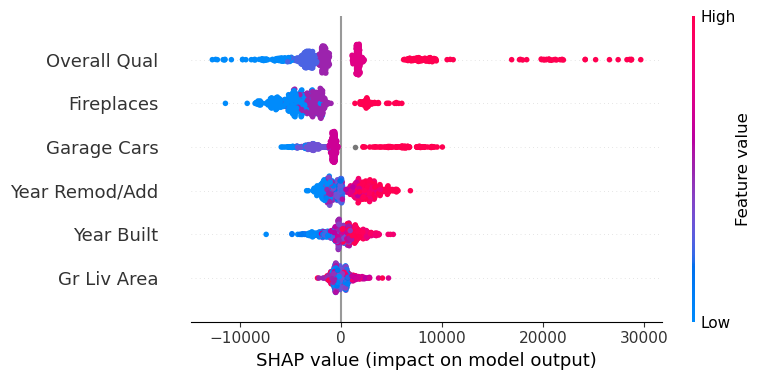

In [23]:
shap.summary_plot(np.array([list(shap_values[i].values()) for i in range(len(shap_values))]), explain_X)

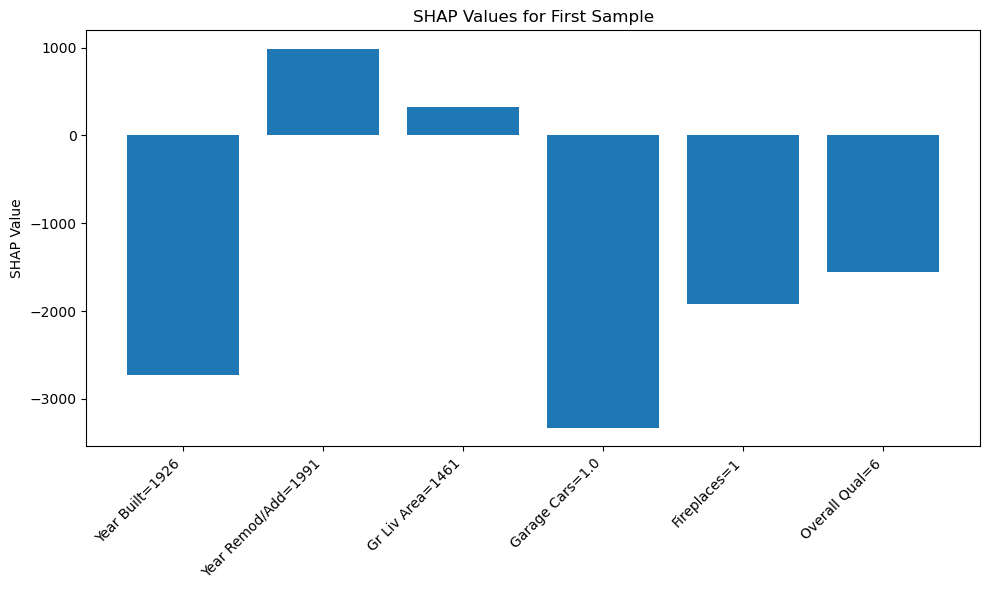

In [39]:
import matplotlib.pyplot as plt

# Convert dictionary to lists for plotting
i = 7
features = [k + "=" + str(explain_X.loc[i, k]) for k in list(shap_values[i].keys())]
values = list(shap_values[i].values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, values)
plt.xticks(rotation=45, ha='right')
plt.title('SHAP Values for First Sample')
plt.ylabel('SHAP Value')
plt.tight_layout()
plt.show()

### ILIV-SHAP explanation on model 1

In [27]:
all_info_model1 = decision_infovalue.DecisionInfoModel(data, "SalePrice", 
                                     signals=["AI1", "human_pred"], 
                                     scoring_rule="mse",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.1)

## Instance complementary information value of each XGBoost model
def info_val_model(X, base_signal):
    y_prob = model1.predict(X)
    return np.array([all_info_model1.instanse_complement_info_value("AI1", base_signal, "AI1", p, base_signals=["human_pred"]) for p in y_prob])

feature_names_ordered_for_plot = list(set(selected_features))

test["AI1"] = model1.predict(test[selected_features])

explain_X = test[feature_names_ordered_for_plot]
i_shap_values = []
for i in tqdm(range(len(explain_X)), desc="Calculating information SHAP values"):
    stored_predictions = {}
    i_shap_values.append(calc_shap_values(partial(info_val_model, 
                                        base_signal = list(test.loc[i, ["AI1"]].values)
                                        ), 
                                        explain_X.loc[i, :], data_grid,
                                        depth = 0))
i_shap_values

Calculating information SHAP values: 100%|██████████| 733/733 [00:29<00:00, 25.07it/s]


[{'Fireplaces': 48824774.57033514,
  'Garage Cars': 44896665.82229888,
  'Gr Liv Area': 0.0,
  'Year Built': 23578932.32684356,
  'Overall Qual': 122001168.47326359,
  'Year Remod/Add': 14748322.818455067},
 {'Fireplaces': 28103704.81001017,
  'Garage Cars': 41849627.66269118,
  'Gr Liv Area': 0.0,
  'Year Built': 23194521.08327637,
  'Overall Qual': 124276572.69660233,
  'Year Remod/Add': 18142278.949849483},
 {'Fireplaces': 68252490.59425826,
  'Garage Cars': 143123557.22933972,
  'Gr Liv Area': 11930445.223329417,
  'Year Built': 43927172.47960561,
  'Overall Qual': 264636618.6702209,
  'Year Remod/Add': 50414285.46708446},
 {'Fireplaces': 36979462.15064103,
  'Garage Cars': 151826816.11613134,
  'Gr Liv Area': 15350158.451047573,
  'Year Built': 26435001.763193004,
  'Overall Qual': 368128843.4567148,
  'Year Remod/Add': 59705597.19613549},
 {'Fireplaces': 66881104.31758012,
  'Garage Cars': 125535894.83561951,
  'Gr Liv Area': 22177111.919565618,
  'Year Built': 97600487.11727224,

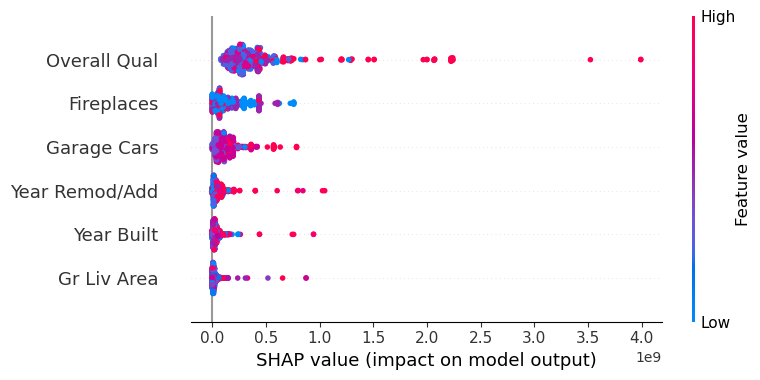

In [28]:
shap.summary_plot(np.array([list(i_shap_values[i].values()) for i in range(len(i_shap_values))]), explain_X)

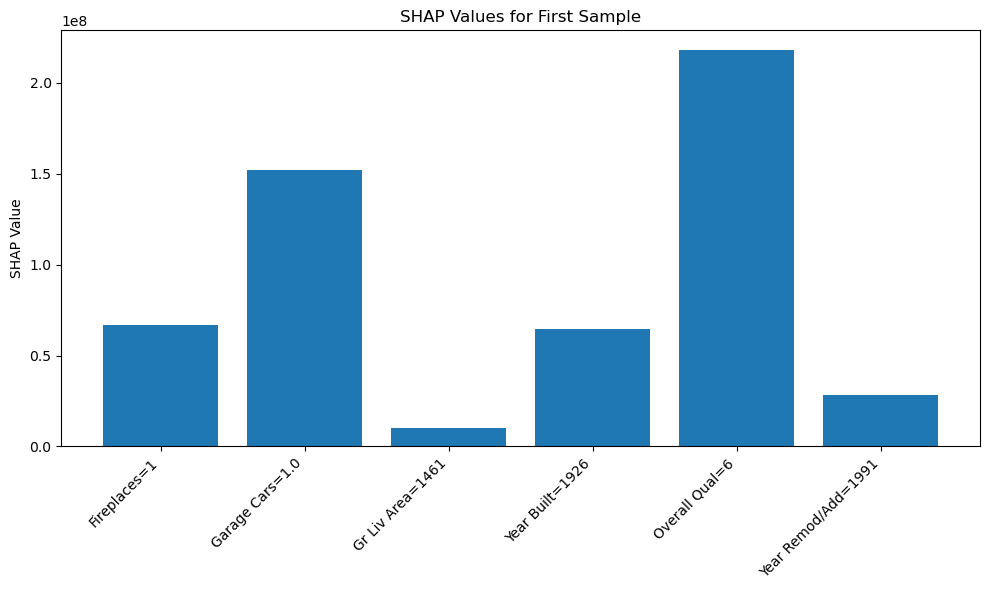

In [29]:
i = 7
features = [k + "=" + str(explain_X.loc[i, k]) for k in list(i_shap_values[i].keys())]
values = list(i_shap_values[i].values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, values)
plt.xticks(rotation=45, ha='right')
plt.title('SHAP Values for First Sample')
plt.ylabel('SHAP Value')
plt.tight_layout()
plt.show()

### SHAP explanation on model 2

In [31]:
explain_X = test[selected_features]
shap_values2 = []
from tqdm import tqdm
for i in tqdm(range(len(explain_X)), desc="Calculating SHAP values"):
    stored_predictions = {}
    shap_values2.append(calc_shap_values(model2.predict, explain_X.loc[i, :], data_grid, depth = 0))
shap_values2

Calculating SHAP values: 100%|██████████| 733/733 [00:07<00:00, 93.06it/s]


[{'Year Built': -3090.7083333333335,
  'Year Remod/Add': 0.0,
  'Gr Liv Area': -3843.9466145833335,
  'Garage Cars': -992.87890625,
  'Fireplaces': -3187.2291666666665,
  'Overall Qual': 0.0},
 {'Year Built': -3969.3528645833335,
  'Year Remod/Add': 0.0,
  'Gr Liv Area': 827.7825520833334,
  'Garage Cars': -1275.1393229166667,
  'Fireplaces': -4093.3111979166665,
  'Overall Qual': 0.0},
 {'Year Built': -4995.514322916667,
  'Year Remod/Add': 0.0013020833333333333,
  'Gr Liv Area': -806.6471354166666,
  'Garage Cars': -1274.3268229166667,
  'Fireplaces': -1307.1341145833333,
  'Overall Qual': 0.0013020833333333333},
 {'Year Built': -5491.955729166667,
  'Year Remod/Add': -0.0026041666666666665,
  'Gr Liv Area': 2689.3880208333335,
  'Garage Cars': -1728.6588541666667,
  'Fireplaces': 1976.3072916666667,
  'Overall Qual': -0.0026041666666666665},
 {'Year Built': -4441.408854166667,
  'Year Remod/Add': 0.0,
  'Gr Liv Area': -2809.765625,
  'Garage Cars': -1159.015625,
  'Fireplaces': -118

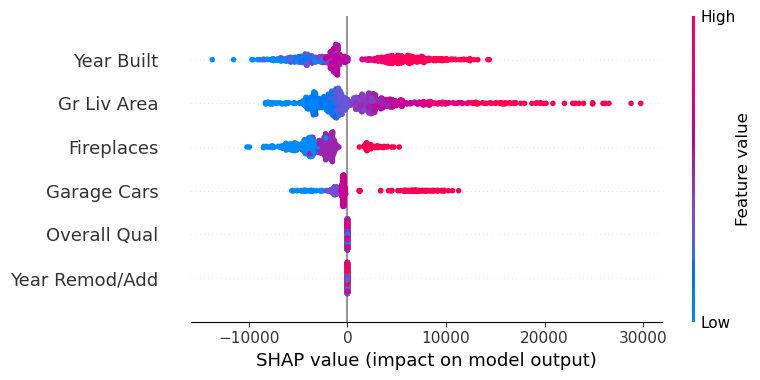

In [32]:
shap.summary_plot(np.array([list(shap_values2[i].values()) for i in range(len(shap_values2))]), explain_X)

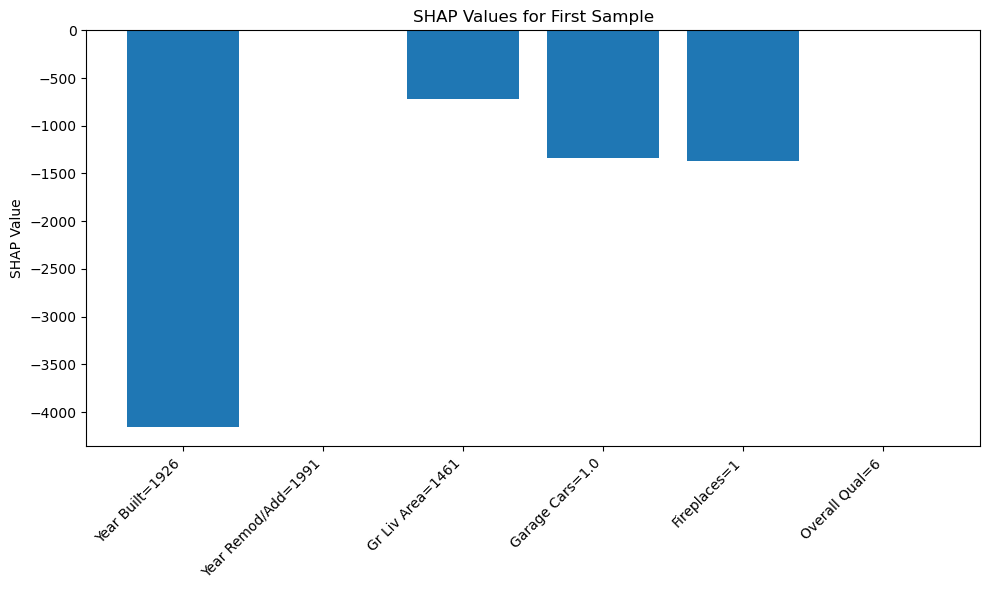

In [38]:
import matplotlib.pyplot as plt

# Convert dictionary to lists for plotting
i = 7
features = [k + "=" + str(explain_X.loc[i, k]) for k in list(shap_values2[i].keys())]
values = list(shap_values2[i].values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, values)
plt.xticks(rotation=45, ha='right')
plt.title('SHAP Values for First Sample')
plt.ylabel('SHAP Value')
plt.tight_layout()
plt.show()

### ILIV-SHAP explanation on model 2

In [34]:
all_info_model2 = decision_infovalue.DecisionInfoModel(data, "SalePrice", 
                                     signals=["AI2", "human_pred"], 
                                     scoring_rule="mse",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.1)

## Instance complementary information value of each XGBoost model
def info_val_model(X, base_signal):
    y_prob = model2.predict(X)
    return np.array([all_info_model2.instanse_complement_info_value("AI2", base_signal, "AI2", p, base_signals=["human_pred"]) for p in y_prob])

feature_names_ordered_for_plot = list(set(selected_features))

test["AI2"] = model2.predict(test[selected_features])

explain_X = test[feature_names_ordered_for_plot]
i_shap_values2 = []
for i in tqdm(range(len(explain_X)), desc="Calculating information SHAP values"):
    stored_predictions = {}
    i_shap_values2.append(calc_shap_values(partial(info_val_model, 
                                        base_signal = list(test.loc[i, ["AI2"]].values)
                                        ), 
                                        explain_X.loc[i, :], data_grid,
                                        depth = 0))
i_shap_values2

Calculating information SHAP values: 100%|██████████| 733/733 [00:29<00:00, 24.81it/s]


[{'Fireplaces': 194505886.89354357,
  'Garage Cars': 78833306.82267608,
  'Gr Liv Area': 271414767.33025086,
  'Year Built': 212962194.35871825,
  'Overall Qual': 0.0,
  'Year Remod/Add': 0.0},
 {'Fireplaces': 79042612.35050406,
  'Garage Cars': 77087790.18616557,
  'Gr Liv Area': 63566286.74825623,
  'Year Built': 172759656.76183763,
  'Overall Qual': 0.0,
  'Year Remod/Add': 0.0},
 {'Fireplaces': 103446846.82647745,
  'Garage Cars': 76614066.67873451,
  'Gr Liv Area': 70414684.8184602,
  'Year Built': 217725835.65818292,
  'Overall Qual': 0.0,
  'Year Remod/Add': 0.0},
 {'Fireplaces': 35269716.140722804,
  'Garage Cars': 146770218.47273874,
  'Gr Liv Area': 116227289.36363776,
  'Year Built': 611703599.7637475,
  'Overall Qual': 0.0,
  'Year Remod/Add': 0.0},
 {'Fireplaces': 43595588.82312512,
  'Garage Cars': 116769842.93600759,
  'Gr Liv Area': 139649765.3229409,
  'Year Built': 241122114.8071488,
  'Overall Qual': 0.0,
  'Year Remod/Add': 0.0},
 {'Fireplaces': 81806366.26395305,
 

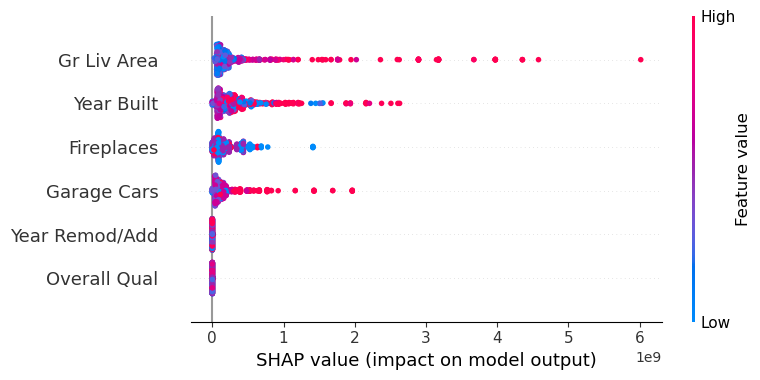

In [36]:
shap.summary_plot(np.array([list(i_shap_values2[i].values()) for i in range(len(i_shap_values2))]), explain_X)

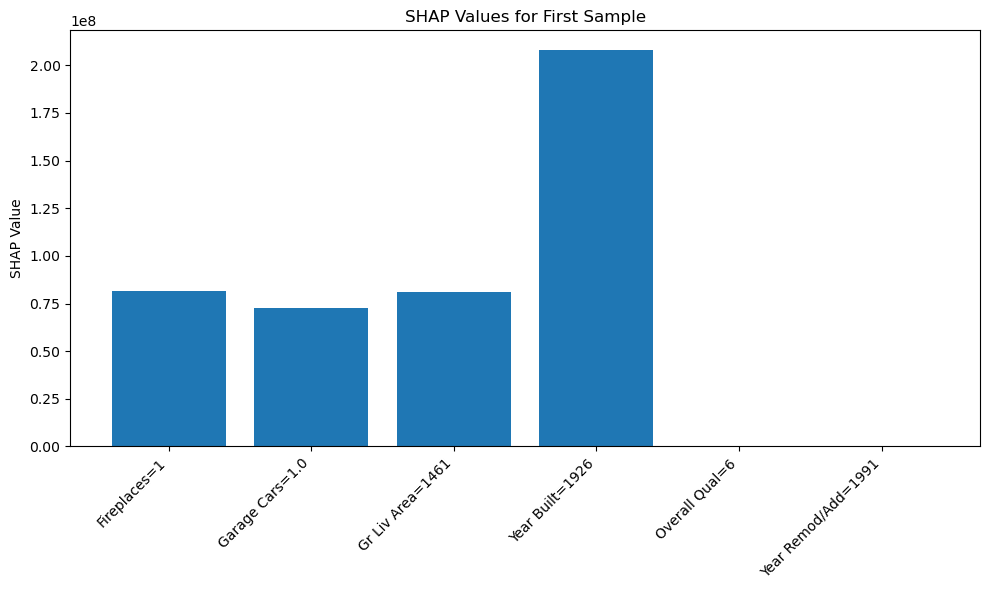

In [37]:
i = 7
features = [k + "=" + str(explain_X.loc[i, k]) for k in list(i_shap_values2[i].keys())]
values = list(i_shap_values2[i].values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, values)
plt.xticks(rotation=45, ha='right')
plt.title('SHAP Values for First Sample')
plt.ylabel('SHAP Value')
plt.tight_layout()
plt.show()

## Generating experimental data

In [54]:
survey_data, _ = decision_infovalue.get_dataset("housing", with_human_data = False)
survey_test_data = survey_data[survey_data["is_train"] != True].reset_index(drop=True)
survey_test_data["SalePrice"] = survey_data["SalePrice"]
survey_test_data["pred1"] = model1.predict(survey_test_data[selected_features])
survey_test_data["pred2"] = model2.predict(survey_test_data[selected_features])
survey_test_data["Overall Qual"] = survey_test_data["Overall Qual"] * 20
survey_test_data["Year Remod/Add"] = 40500 - survey_test_data["Year Remod/Add"] * 20
survey_test_data.columns = [f.replace(" ", "_") if f != "Year Remod/Add" else "Year_Remod" for f in survey_test_data.columns]

shap_values = [{f.replace(" ", "_") if f != "Year Remod/Add" else "Year_Remod": v for f, v in sv.items()} for sv in shap_values]
shap_values2 = [{f.replace(" ", "_") if f != "Year Remod/Add" else "Year_Remod": v for f, v in sv.items()} for sv in shap_values2]
i_shap_values = [{f.replace(" ", "_") if f != "Year Remod/Add" else "Year_Remod": v for f, v in sv.items()} for sv in i_shap_values]
i_shap_values2 = [{f.replace(" ", "_") if f != "Year Remod/Add" else "Year_Remod": v for f, v in sv.items()} for sv in i_shap_values2]

for key in shap_values[0].keys():
    survey_test_data["shap_values_" + key] = [shap_value[key] / 1000 for shap_value in shap_values]
for key in shap_values2[0].keys():
    if key != "Year_Remod" and key != "Overall_Qual":
        survey_test_data["shap_values2_" + key] = [shap_value[key] / 1000 for shap_value in shap_values2]
    else:
        survey_test_data["shap_values2_" + key] = [0 for shap_value in shap_values2]
for key in i_shap_values[0].keys():
    survey_test_data["i_shap_values_" + key] = [shap_value[key] / 1000000 for shap_value in i_shap_values]
for key in i_shap_values2[0].keys():
    if key != "Year_Remod" and key != "Overall_Qual":
        survey_test_data["i_shap_values2_" + key] = [shap_value[key] / 1000000 for shap_value in i_shap_values2]
    else:
        survey_test_data["i_shap_values2_" + key] = [0 for shap_value in i_shap_values2]

survey_test_data = survey_test_data.sample(frac=1, random_state=27).reset_index(drop=True)
survey_test_data.loc[:, "group_id"] = survey_test_data.index // 12

f_names_survey = [f.replace(" ", "_") if f != "Year Remod/Add" else "Year_Remod" for f in feature_names_ordered_for_plot]

survey_test_data[f_names_survey + 
                 ["shap_values_" + f for f in f_names_survey] + 
                 ["shap_values2_" + f for f in f_names_survey] + 
                 ["i_shap_values_" + f for f in f_names_survey] + 
                 ["i_shap_values2_" + f for f in f_names_survey] + 
                 ["SalePrice", "Order", "PID", "pred1", "pred2", "group_id"]].to_csv("./notebooks/house-price-example/survey_data.csv", index = False)
